In [9]:
%pip install pandas seaborn scikit-learn tensorflow

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.75.1-cp311-cp311-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.15.1-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached m

# Import Libraries

In [10]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


# Dataset Prep

In [97]:
data_path = r"D:\GLAZE-evaluation\dataset\train"

images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        full_image_path = os.path.join(subfolder_path, image_filename)
        images.append(full_image_path)
        labels.append(subfolder)
        
data = pd.DataFrame({'image': images, 'label': labels})

In [98]:
train_df, valid_test_df = train_test_split(
    data, 
    test_size=0.2, # 20% for validation/test
    stratify=data['label'], 
    random_state=123
)

valid_df, test_df = train_test_split(
    valid_test_df, 
    test_size=0.5, # Split the 20% into two 10% halves
    stratify=valid_test_df['label'], 
    random_state=123
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Total images found: {len(data)}")
print(f"Train DF size: {len(train_df)}")
print(f"Validation DF size: {len(valid_df)}")
print(f"Test DF size: {len(test_df)}")

Total images found: 400
Train DF size: 320
Validation DF size: 40
Test DF size: 40


In [99]:
data.shape

(400, 2)

In [100]:
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    color_mode='rgb', 
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [101]:
print(len(train_df))
print(len(valid_df))
print(len(test_df))

320
40
40


# InceptionV3 tuning

In [102]:
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape
)

In [103]:
for layer in base_model.layers:
    layer.trainable = False

In [104]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [105]:
model = Model(inputs=base_model.input, outputs=predictions)

In [106]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [107]:
checkpoint = ModelCheckpoint(
    'roko_style.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

In [108]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5071 - loss: 14.9312
Epoch 1: val_accuracy improved from None to 0.65625, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5281 - loss: 13.0935 - val_accuracy: 0.6562 - val_loss: 4.9405 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6354 - loss: 6.4180
Epoch 2: val_accuracy did not improve from 0.65625
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6344 - loss: 6.4371 - val_accuracy: 0.6562 - val_loss: 5.4056 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6544 - loss: 5.2016
Epoch 3: val_accuracy did not improve from 0.65625
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6406 - loss: 4.7697 - val_accuracy: 0.6250 - val_loss: 4.8589 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7279 - loss: 4.1017
Epoch 4: val_accuracy improved from 0.65625 to 0.68750, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7406 - loss: 3.2617 - val_accuracy: 0.6875 - val_loss: 2.7715 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7332 - loss: 2.8265
Epoch 5: val_accuracy did not improve from 0.68750
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7125 - loss: 2.9220 - val_accuracy: 0.5625 - val_loss: 6.1694 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7105 - loss: 2.6644
Epoch 6: val_accuracy improved from 0.68750 to 0.75000, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7406 - loss: 2.4207 - val_accuracy: 0.7500 - val_loss: 2.2907 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8261 - loss: 1.1711
Epoch 7: val_accuracy improved from 0.75000 to 0.81250, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8219 - loss: 1.2205 - val_accuracy: 0.8125 - val_loss: 1.0664 - learning_rate: 0.0010
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8250 - loss: 1.1510
Epoch 8: val_accuracy improved from 0.81250 to 0.84375, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8188 - loss: 1.2382 - val_accuracy: 0.8438 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8450 - loss: 0.8658
Epoch 9: val_accuracy did not improve from 0.84375
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8313 - loss: 0.8995 - val_accuracy: 0.8125 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8216 - loss: 0.6402
Epoch 10: val_accuracy improved from 0.84375 to 0.87500, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8094 - loss: 0.6665 - val_accuracy: 0.8750 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8377 - loss: 0.6456
Epoch 11: val_accuracy did not improve from 0.87500
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8125 - loss: 0.8372 - val_accuracy: 0.7812 - val_loss: 0.7867 - learning_rate: 0.0010
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8213 - loss: 0.8989
Epoch 12: val_accuracy did not improve from 0.87500
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8156 - loss: 0.8979 - val_accuracy: 0.6250 - val_loss: 0.8691 - learning_rate: 0.0010
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8417 - loss: 0.6441
Epoch 13: val_accuracy did not improve from 0.87500
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8188 - loss: 0.6434 - val_accuracy: 0.8438 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━

In [109]:
model.load_weights('roko_style.h5')
model.save('roko_style_predictor.h5')

# Evaluation

In [110]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.8500 - loss: 0.7058
Test Accuracy: 0.8500
Test Loss: 0.7058


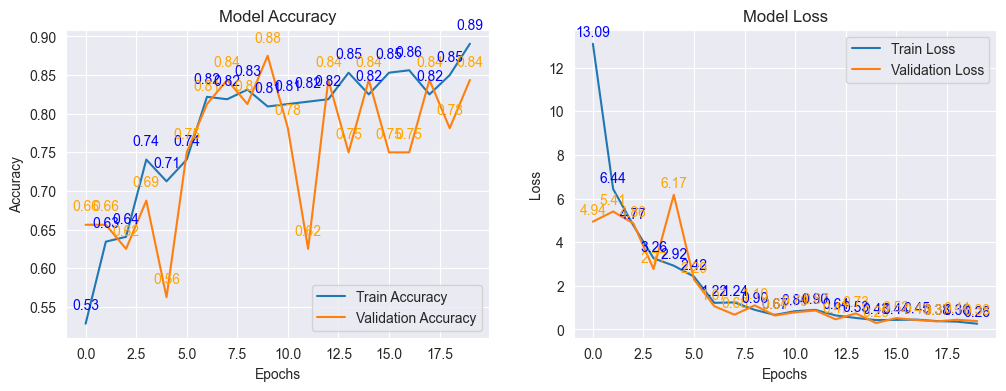

In [111]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12,4))
    
    # Subplot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Add numbers to each node in accuracy line
    for i in range(len(history.history['accuracy'])):
        plt.annotate(f"{history.history['accuracy'][i]:.2f}", 
                     (i, history.history['accuracy'][i]),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center', color='blue')
        plt.annotate(f"{history.history['val_accuracy'][i]:.2f}", 
                     (i, history.history['val_accuracy'][i]),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center', color='orange')
    # Subplot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Add numbers to each node in loss line
    for i in range(len(history.history['loss'])):
        plt.annotate(f'{history.history["loss"][i]:.2f}',
                     (i, history.history['loss'][i]),
                     textcoords="offset points",
                     xytext=(0,5), ha='center', color='blue')
        plt.annotate(f'{history.history["val_loss"][i]:.2f}',
                     (i, history.history['val_loss'][i]),
                     textcoords="offset points",
                     xytext=(0,5), ha='center', color='orange')
        
    plt.show()

plot_history(history)

In [112]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [113]:
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

512-lora-ori       0.50      1.00      0.67        20
     512-ori       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



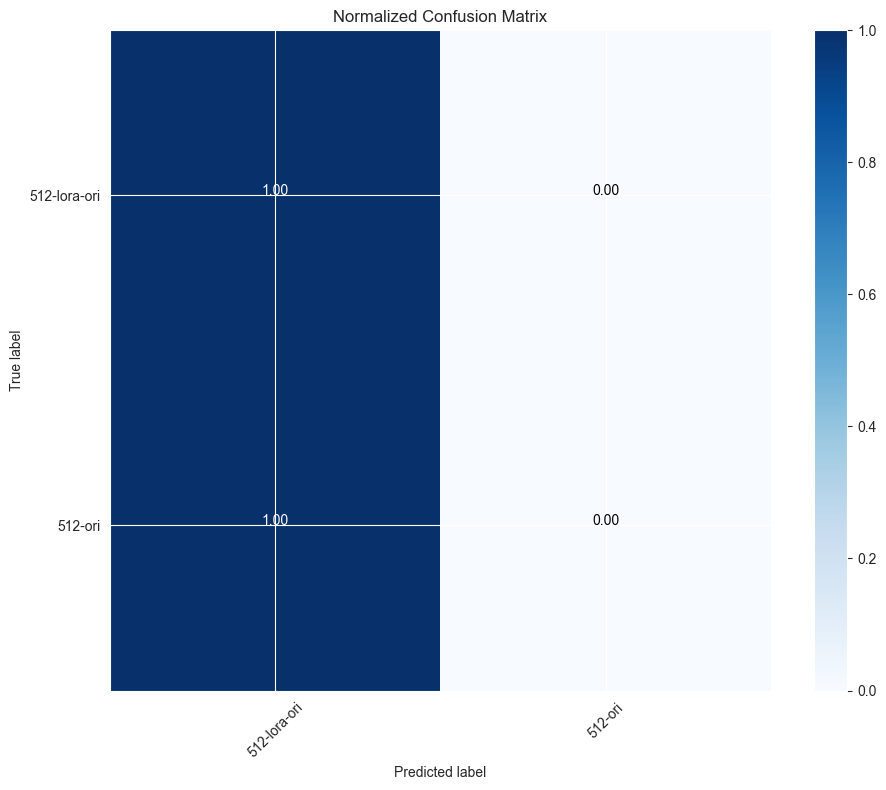

In [114]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, without Normalization'
    
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, class_labels, normalize=True)

# Test for Glaze & LoRA-Glazed dataset

In [90]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5721 - loss: 25.7072
Epoch 1: val_accuracy improved from None to 0.75000, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6094 - loss: 16.7690 - val_accuracy: 0.7500 - val_loss: 2.0924 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6237 - loss: 11.4032
Epoch 2: val_accuracy did not improve from 0.75000
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6719 - loss: 9.4169 - val_accuracy: 0.5938 - val_loss: 5.5777 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7641 - loss: 5.2709
Epoch 3: val_accuracy improved from 0.75000 to 0.81250, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.7719 - loss: 4.4236 - val_accuracy: 0.8125 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8059 - loss: 3.4708
Epoch 4: val_accuracy improved from 0.81250 to 0.87500, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8031 - loss: 3.1865 - val_accuracy: 0.8750 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8089 - loss: 2.4223
Epoch 5: val_accuracy did not improve from 0.87500
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8313 - loss: 1.9468 - val_accuracy: 0.8125 - val_loss: 1.2539 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7887 - loss: 2.2437
Epoch 6: val_accuracy did not improve from 0.87500
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7937 - loss: 2.1288 - val_accuracy: 0.8750 - val_loss: 0.5715 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8792 - loss: 1.2096
Epoch 7: val_accuracy improved from 0.87500 to 0.90625, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8594 - loss: 1.3679 - val_accuracy: 0.9062 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8392 - loss: 1.3682
Epoch 8: val_accuracy improved from 0.90625 to 0.96875, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8625 - loss: 1.3347 - val_accuracy: 0.9688 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8494 - loss: 1.3681
Epoch 9: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8594 - loss: 1.3008 - val_accuracy: 0.9062 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8641 - loss: 1.6085
Epoch 10: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8625 - loss: 1.3095 - val_accuracy: 0.8125 - val_loss: 0.6674 - learning_rate: 0.0010
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8309 - loss: 1.2128
Epoch 11: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8438 - loss: 1.0955 - val_accuracy: 0.7500 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━

In [92]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.8500 - loss: 0.9316
Test Accuracy: 0.8500
Test Loss: 0.9316


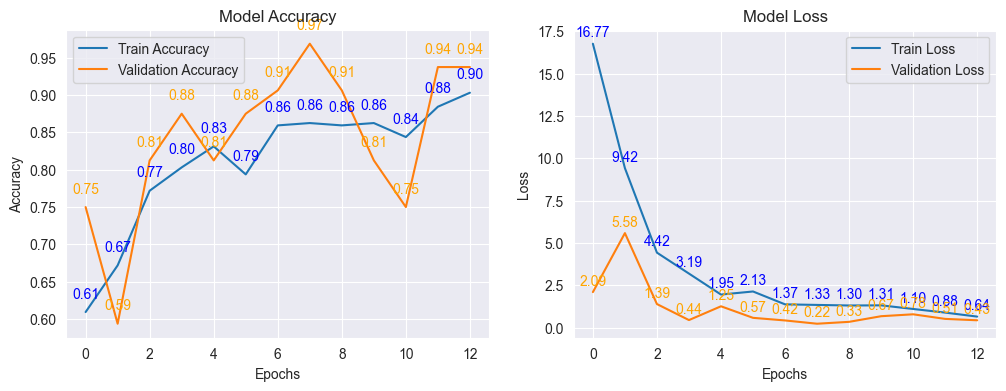

In [93]:
plot_history(history)

In [95]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step
              precision    recall  f1-score   support

     512-glz       0.50      1.00      0.67        20
512-lora-glz       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



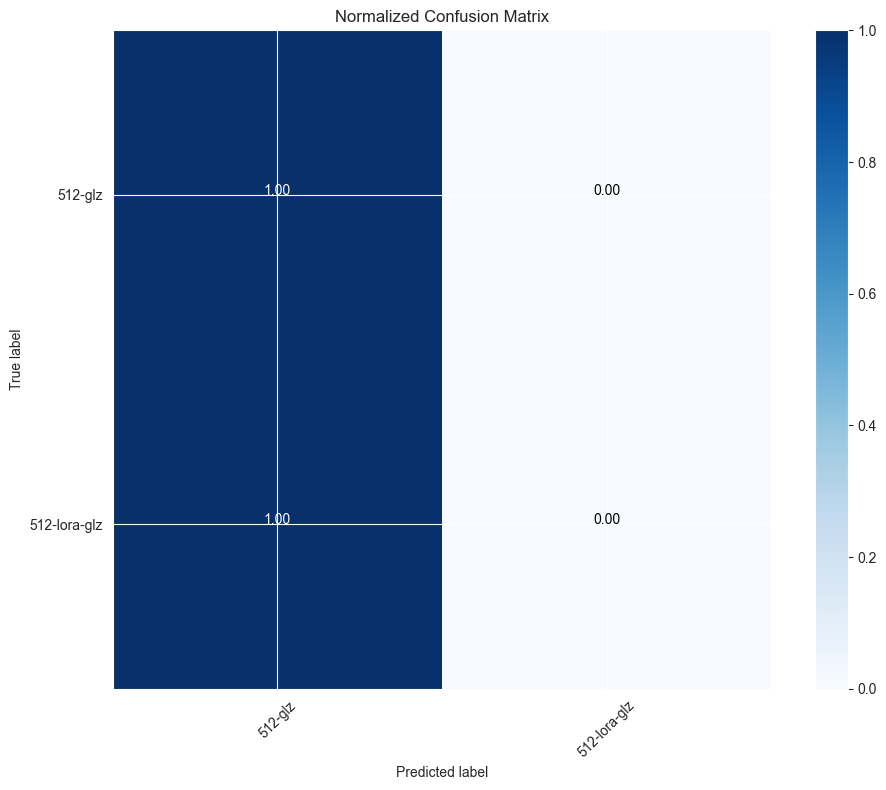

In [96]:
plot_confusion_matrix(y_true, y_pred_classes, class_labels, normalize=True)

# Test for Original & LoRA-Glazed

In [71]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5383 - loss: 19.0018
Epoch 1: val_accuracy improved from None to 0.62500, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5344 - loss: 19.4847 - val_accuracy: 0.6250 - val_loss: 2.4689 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6091 - loss: 7.7678
Epoch 2: val_accuracy improved from 0.62500 to 0.75000, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6062 - loss: 7.9137 - val_accuracy: 0.7500 - val_loss: 1.8964 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6380 - loss: 6.2818
Epoch 3: val_accuracy did not improve from 0.75000
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6781 - loss: 5.1607 - val_accuracy: 0.7188 - val_loss: 2.5667 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 4.8100
Epoch 4: val_accuracy improved from 0.75000 to 0.78125, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7812 - loss: 3.9726 - val_accuracy: 0.7812 - val_loss: 1.6145 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7710 - loss: 3.2251
Epoch 5: val_accuracy improved from 0.78125 to 0.81250, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7875 - loss: 2.7880 - val_accuracy: 0.8125 - val_loss: 1.0486 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7483 - loss: 2.7888
Epoch 6: val_accuracy improved from 0.81250 to 0.84375, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7719 - loss: 2.5378 - val_accuracy: 0.8438 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7917 - loss: 1.9236
Epoch 7: val_accuracy did not improve from 0.84375
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8031 - loss: 2.1415 - val_accuracy: 0.8125 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7960 - loss: 2.0326
Epoch 8: val_accuracy improved from 0.84375 to 0.87500, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8406 - loss: 1.5976 - val_accuracy: 0.8750 - val_loss: 0.7064 - learning_rate: 0.0010
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8849 - loss: 1.0032
Epoch 9: val_accuracy improved from 0.87500 to 0.90625, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8594 - loss: 1.3682 - val_accuracy: 0.9062 - val_loss: 0.8601 - learning_rate: 0.0010
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9250 - loss: 0.5284
Epoch 10: val_accuracy improved from 0.90625 to 0.93750, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9156 - loss: 0.5646 - val_accuracy: 0.9375 - val_loss: 0.4528 - learning_rate: 2.0000e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9057 - loss: 0.5613
Epoch 11: val_accuracy did not improve from 0.93750
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9187 - loss: 0.4893 - val_accuracy: 0.9375 - val_loss: 0.3871 - learning_rate: 2.0000e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8998 - loss: 0.6424
Epoch 12: val_accuracy did not improve from 0.93750
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9187 - loss: 0.5187 - val_accuracy: 0.9375 - val_loss: 0.3274 - learning_rate: 2.0000e-04
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9133 - loss: 0.4569
Epoch 13: val_accuracy did not improve from 0.93750
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8969 - loss: 0.5717 - val_accuracy: 0.9375 - val_loss: 0.1761 - learning_rate: 2.0000e-04
Epoch 14/20
10/10 ━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9094 - loss: 0.4346 - val_accuracy: 0.9688 - val_loss: 0.1444 - learning_rate: 2.0000e-04
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9510 - loss: 0.2243
Epoch 15: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9594 - loss: 0.2054 - val_accuracy: 0.9375 - val_loss: 0.1557 - learning_rate: 2.0000e-04
Epoch 16/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9267 - loss: 0.3530
Epoch 16: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9250 - loss: 0.3681 - val_accuracy: 0.9688 - val_loss: 0.0830 - learning_rate: 2.0000e-04
Epoch 17/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9271 - loss: 0.3654
Epoch 17: val_accuracy did not improve from 0.96875
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9156 - loss: 0.3953 - val_accuracy: 0.9375 - val_loss: 0.2102 - learning_rate: 2.0000e-04
Epoch 18/20
10/10 ━━

In [73]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9750 - loss: 0.1140
Test Accuracy: 0.9750
Test Loss: 0.1140


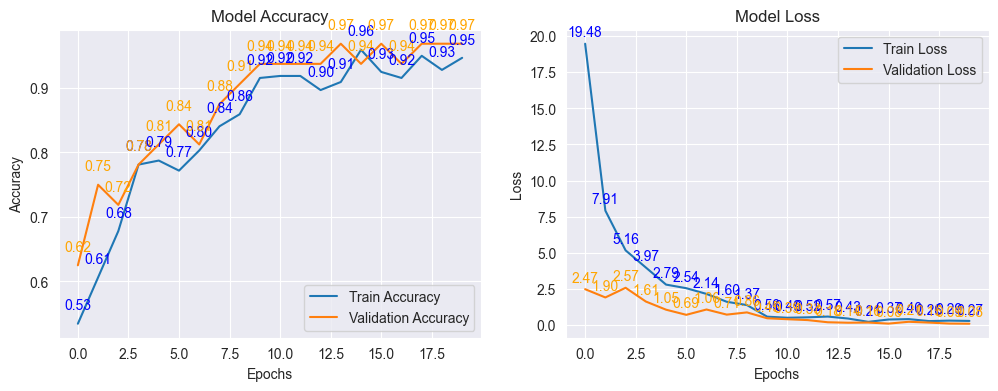

In [74]:
plot_history(history)

In [76]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
              precision    recall  f1-score   support

512-lora-glz       0.50      1.00      0.67        20
     512-ori       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



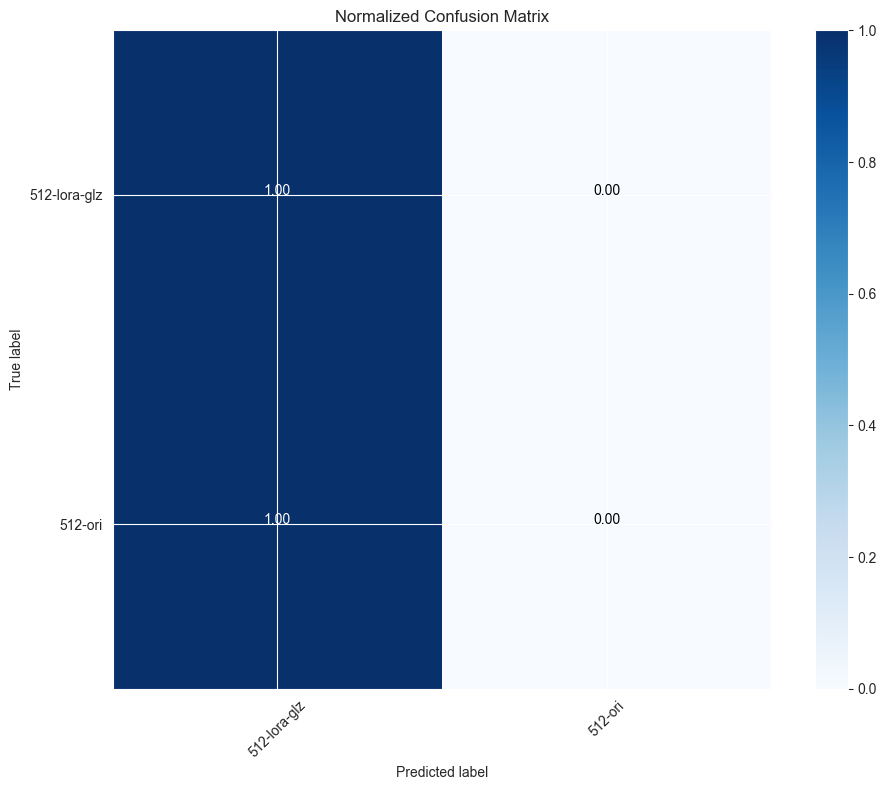

In [77]:
plot_confusion_matrix(y_true, y_pred_classes, class_labels, normalize=True)